In [78]:
# Step 1: Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.model_selection import GridSearchCV


In [79]:

data_directory = "/Users/navd/Downloads/IndianCurrencyNotesDataset/AllImages"
batch_size = 32
image_size = (224, 224)


In [80]:

# Create a labeled dataset from a directory
train_data = image_dataset_from_directory(
    data_directory,
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    batch_size=batch_size,
    validation_split=.2,
    subset="training",
    seed=123,
    shuffle=True
)

validation_data = image_dataset_from_directory(
    data_directory,
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    batch_size=batch_size,
    validation_split=.2,
    subset="validation",
    seed=123,
    shuffle=True
)


Found 178 files belonging to 7 classes.
Using 143 files for training.
Found 178 files belonging to 7 classes.
Using 35 files for validation.


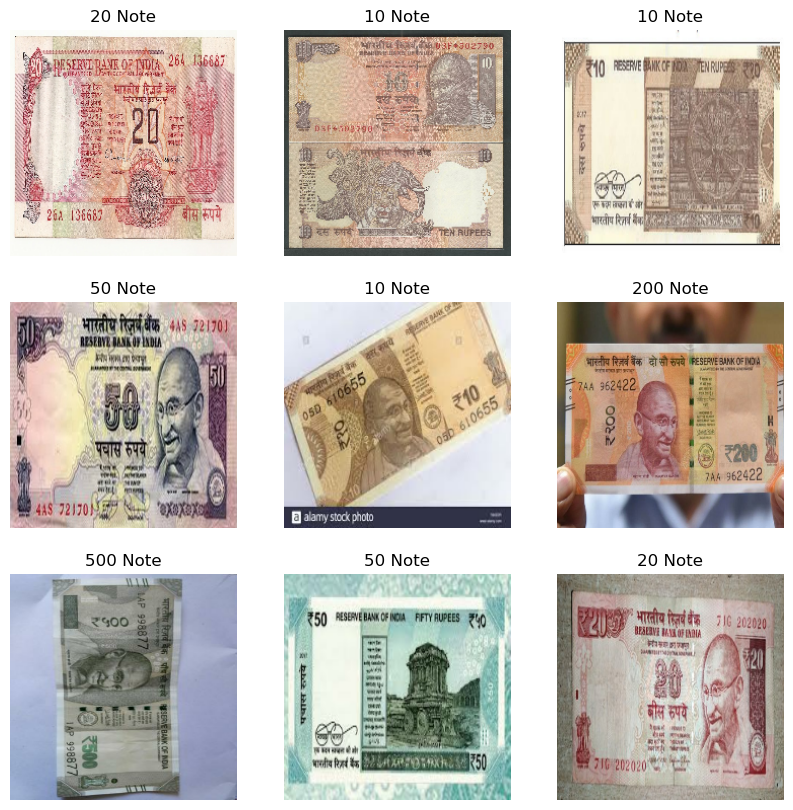

In [81]:

categories = train_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(categories[labels[i]])
        plt.axis("off")
plt.show()

data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])
augmented_train_data = train_data.map(lambda x, y: (data_augmentation(x), y))


In [82]:

# Step 4: Load pretrained ResNet50 model
resnet_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg',
    classes=7,
)
resnet_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_13[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [83]:

features_list = []
labels_list = []

for images, labels in augmented_train_data:
    preprocessed_images = preprocess_input(images)
    
    features = resnet_model.predict(preprocessed_images)
    
    features_list.append(features)
    labels_list.append(labels.numpy())
features_array = np.concatenate(features_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

print("Shape of features array:", features_array.shape)
print("Shape of labels array:", labels_array.shape)


1/1 [==============================] - 1s 641ms/step
Shape of features array: (143, 2048)
Shape of labels array: (143,)


In [84]:
test_features_list = []
test_labels_list = []
# Extract features and labels
for images, labels in validation_data:
    # Preprocess images for ResNet50 model
    preprocessed_images = preprocess_input(images)
    
    # Extract features using the pre-trained ResNet50 model
    features = resnet_model.predict(preprocessed_images)
    
    # Append features and labels to the lists
    test_features_list.append(features)
    test_labels_list.append(labels.numpy())

# Convert lists to NumPy arrays
test_features_array = np.concatenate(test_features_list, axis=0)
test_labels_array = np.concatenate(test_labels_list, axis=0)

# Display the shapes of the extracted features and labels
print("Shape of features array:", test_features_array.shape)
print("Shape of labels array:", test_labels_array.shape)


1/1 [==============================] - 0s 110ms/step
Shape of features array: (35, 2048)
Shape of labels array: (35,)


Best Hyperparameters: {'C': 0.1, 'kernel': 'linear'}
Best Accuracy: 0.8669950738916257
Best Model Accuracy: 88.57%


<Figure size 800x600 with 0 Axes>

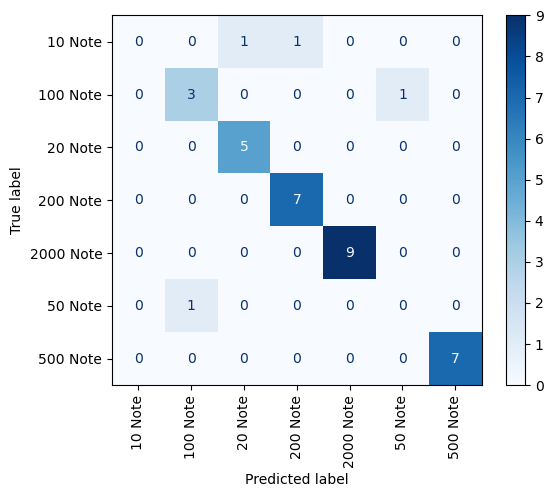

In [85]:

# Define the parameter grid to search
parameter_grid = {
    'C': [0.1, 1, 10, 100],  # You can adjust the range of C values
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # You can adjust the list of kernel functions
}

# Create an SVM classifier
svm_classifier = SVC()

# Create the GridSearchCV object
grid_search_cv = GridSearchCV(svm_classifier, parameter_grid, cv=5, scoring='accuracy')

# Perform the grid search on your training data
grid_search_cv.fit(features_array, labels_array)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", grid_search_cv.best_params_)
print("Best Accuracy:", grid_search_cv.best_score_)

# Get the best model from the grid search
best_svm_classifier = grid_search_cv.best_estimator_

# Make predictions on the test set using the best model
best_predictions = best_svm_classifier.predict(test_features_array)

# Calculate accuracy and print confusion matrix for the best model
best_accuracy = accuracy_score(test_labels_array, best_predictions)
print(f'Best Model Accuracy: {best_accuracy * 100:.2f}%')

best_confusion_matrix = confusion_matrix(test_labels_array, best_predictions)

plt.figure(figsize=(8, 6))

best_confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=best_confusion_matrix, display_labels=categories)

best_confusion_matrix_display.plot(cmap=plt.cm.Blues, xticks_rotation=90)

plt.show()


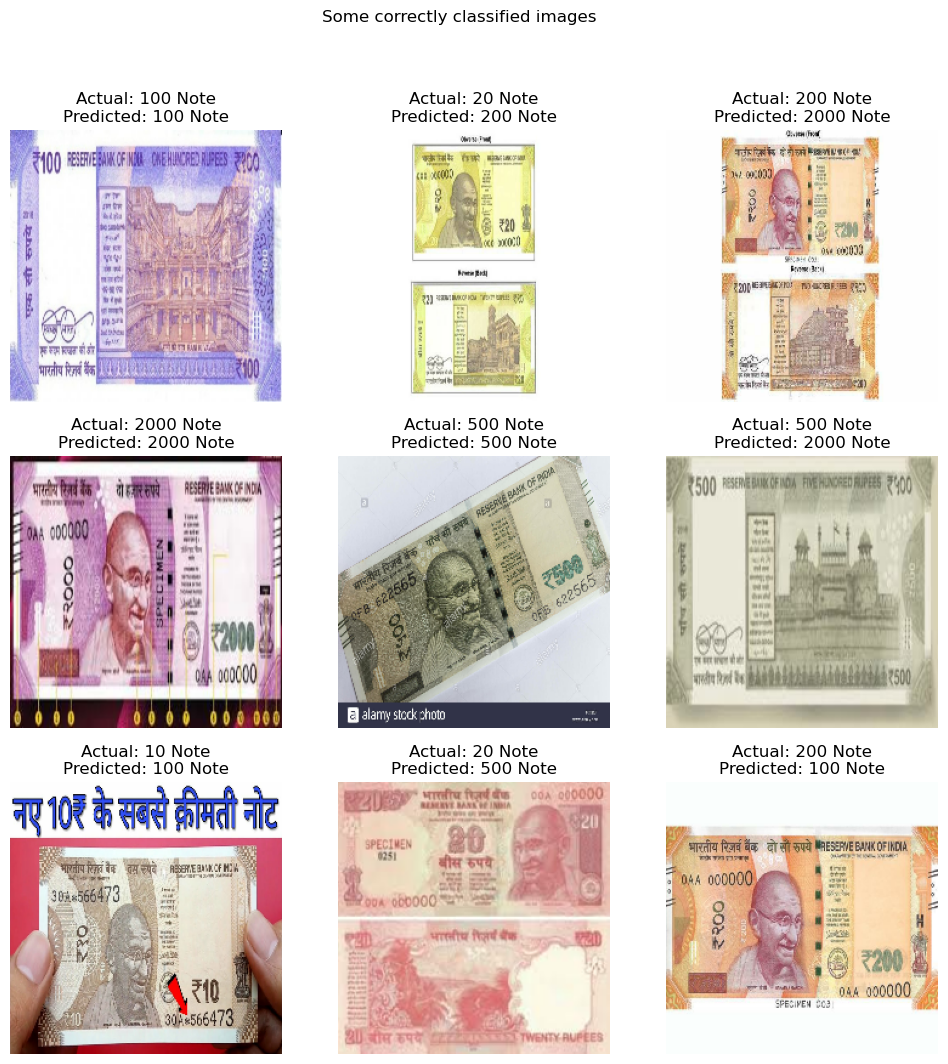

In [86]:
correctly_classified_indices = np.where(test_labels_array == best_predictions)[0]
num_correctly_classified_images = min(9, len(correctly_classified_indices))

plt.figure(figsize=(12, 12))
for i in range(num_correctly_classified_images):
    ax = plt.subplot(3, 3, i + 1)
    index = correctly_classified_indices[i]
    img, actual_label = val_dataset.unbatch().skip(index).take(1).as_numpy_iterator().next()
    img = img.astype("uint8")
    predicted_label = class_names[best_predictions[index]]
    
    plt.imshow(img)
    plt.title(f'Actual: {class_names[actual_label]}\nPredicted: {predicted_label}')
    plt.axis("off")
plt.suptitle("Some correctly classified images")
plt.show()


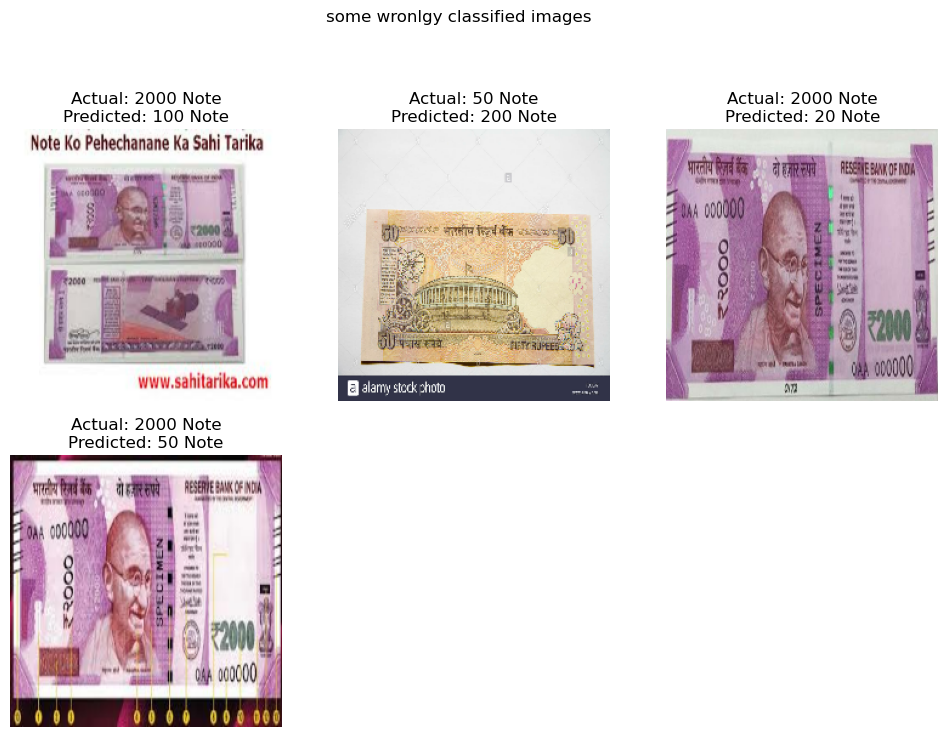

In [87]:
wrongly_classified_indices = np.where(test_labels_array != best_predictions)[0]
num_wrongly_classified_images = min(9, len(wrongly_classified_indices))

plt.figure(figsize=(12, 12))
for i in range(num_wrongly_classified_images):
    ax = plt.subplot(3, 3, i + 1)
    index = wrongly_classified_indices[i]
    img, actual_label = val_dataset.unbatch().skip(index).take(1).as_numpy_iterator().next()
    img = img.astype("uint8")
    predicted_label = class_names[best_predictions[index]]
    
    plt.imshow(img)
    plt.title(f'Actual: {class_names[actual_label]}\nPredicted: {predicted_label}')
    plt.axis("off")
plt.suptitle("some wronlgy classified images")
plt.show()